In [40]:
import numpy as np
import scipy.optimize as sopt
import casadi.casadi as cs
import matplotlib.pyplot as plt

You may find detailed documentation on `scipy.optimize` [here](https://docs.scipy.org/doc/scipy/tutorial/optimize.html).

## 1. Unconstrained optimisation

Suppose we need to solve the optimisation problem
$$\operatorname*{Minimize}_{x\in{\rm I\!R}}x(x-1)e^x.$$
The cost function is $f(x) = x(x-1)e^x$. In other words, we need to find a point $x^\star$ such that $f(x) \geq f(x^\star)$ for all $x\in{\rm I\!R}$; such point is called a minimiser of $f$. We also need to determine the minimum value of $f$, that is $f^\star = f(x^\star).$

Let us first see how the graph of the function looks like...

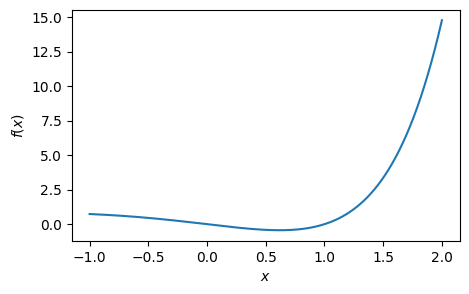

In [41]:
xs = np.linspace(-1, 2, 200)
ys = xs*((xs - 1)*np.exp(xs))

plt.figure(figsize=(5, 3))
plt.plot(xs, ys)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

we see that the minimiser of $f$ is at around $x^\star \approx 0.7$ (roughly).

Let us now solve the optimisation problem numerically using `scipy`.

In [42]:
# 1. We define the cost function using CasADi
def f(x):
    return x*(x-1)*np.exp(x)

# 2. We construct the derivative of f using CasADi
x_ = cs.SX.sym('x')
df_ = cs.gradient(f(x_), x_)
df_fun = cs.Function('df', [x_], [df_])
df = lambda x: float(df_fun(x))

# 3. We solve the problem (we need to provide an initial guess, x0)
x_guess = 0.7
res = sopt.minimize(f, x_guess, method='BFGS', jac=df) # other methods exist (see docs)

# 4. Print the solution
if res.success:
    print(f"Function f has a minimiser at x* ≈ {res.x[0]:.5f}")

Function f has a minimiser at x* ≈ 0.61803


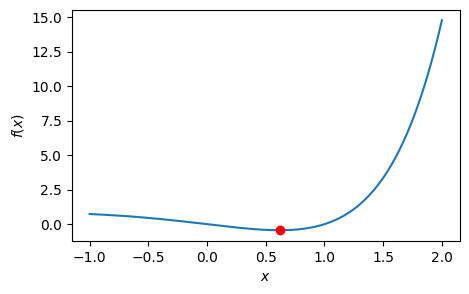

In [43]:
plt.figure(figsize=(5, 3))
plt.plot(xs, f(xs))
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(res.x, res.fun, 'ro') # minimiser + minimum value
plt.show()

## 2. Example with vector decision variable

We want to determine a minimiser of the Rosenbrock function, $r:{\rm I\!R}^n \to {\rm I\!R}^n $, which is given by
$$r(x) = \sum_{i} 10(x_{i+1}-x_{i}^2)^2 + (1-x_i)^2.$$
Let us first plot the function in the case $n=2$...

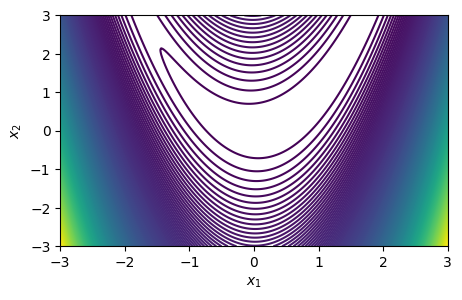

In [44]:
X = np.linspace(-3, 3, 300)
Y = np.linspace(-3, 3, 300)
[X, Y] = np.meshgrid(X, Y)
f = lambda x,y: 10*(y-x**2)**2 + (x-1)**2
plt.figure(figsize=(5, 3))
plt.contour(X, Y, f(X, Y), 250)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

We want to solve the problem
$$\operatorname*{Minimize}_{x\in{\rm I\!R}^2}r(x)$$
In fact, we want to determine a *local* minimiser of $r$.

In [45]:
# 1. We define the cost function using CasADi
def rosen(x):
    return cs.sum(10.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

# 2. We construct the gradient of the Rosenbrock function using CasADi
x_ = cs.SX.sym('x', 2)
rosen_ = rosen(x_)
d_rosen_ = cs.gradient(rosen_, x_)
d_rosen_fun = cs.Function('d_rosen', [x_], [d_rosen_])
d_rosen_lam = lambda x: np.array(d_rosen_fun(x)).flatten()

# 3. Solve the problem
x_guess = [0, 0]
res = sopt.minimize(rosen, x_guess, method='BFGS', jac=d_rosen_lam)

# 4. Print the result
if res.success:
    np.set_printoptions(precision=4)
    print(f"A (local) minimiser was found at x* = {res.x}")
    print(f"The optimal cost is f(x*) = {res.fun:.2e}")

A (local) minimiser was found at x* = [1. 1.]
The optimal cost is f(x*) = 1.29e-15


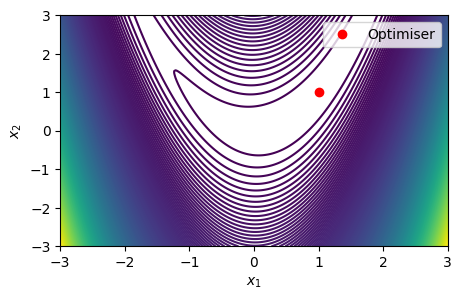

In [46]:
plt.figure(figsize=(5, 3))
plt.contour(X, Y, f(X, Y), 300)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.plot(res.x[0], res.x[1], 'ro', label='Optimiser')
plt.legend()
plt.show()

## 3. Constrained optimisation

### 3.1. Equality constrained problem

We often need to minimise a cost function while imposing certain constraints on the decision variable. The constraints can be *equality constraints* of the form $c(c) = 0$, e.g.,
$$\begin{align*}
\operatorname*{Minimise}_{x\in{\rm I\!R}^n}\;& r(x),
\\
\text{subject to:}\;&x^\intercal x = 2,
\end{align*}$$
where $r$ is the Rosenbrock function.

Let us solve this problem for $n=5$.


In [47]:
# 1A. We define the cost function using CasADi
def rosen(x):
    return cs.sum(10.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

# 1B. We construct the gradient of the cost function using CasADi
nx = 5
x_ = cs.SX.sym('x', nx)
rosen_ = rosen(x_)
d_rosen_ = cs.gradient(rosen_, x_)
d_rosen_fun = cs.Function('d_rosen', [x_], [d_rosen_])
d_rosen_lam = lambda x: np.array(d_rosen_fun(x)).flatten()

# 2A. Define the constraints function c(x) = x'x - 2 using CasADi
def c(x):
    return cs.sumsqr(x) - 2.0

# 2B. Compute the gradient of c(x) using CasADi
dc_ = cs.jacobian(c(x_), x_)
dc_fun = cs.Function('dc', [x_], [dc_])

c_lam = lambda x: float(c(x))
dc_lam = lambda x: np.array(dc_fun(x)).flatten()

# 3. Define the constraints
constr_c = sopt.NonlinearConstraint(c_lam, 0, 0, jac=dc_lam, hess=sopt.BFGS()) # c = 0

# 4. Solve the problem
x0 = np.array([1.3, 0.7, 0.4, 0.3, 0.2])
res = sopt.minimize(rosen, x0,
                    method='trust-constr',
                    jac=d_rosen_lam,
                    constraints=[constr_c])

# 5. Print the result
if res.success:
    np.set_printoptions(precision=4)
    print(f"x* ≈ {res.x}")
    print(f"f(x*) = {res.fun:.4f}")
    print(f"c(x*) ≈ {c_lam(res.x):.2e} (≈ 0)")

x* ≈ [0.8721 0.7819 0.64   0.4326 0.177 ]
f(x*) = 0.5345
c(x*) ≈ 0.00e+00 (≈ 0)


### 3.2. Bounds and inequality constraints

Consider the problem
$$\begin{align*}
\operatorname*{Minimise}_{x\in{\rm I\!R}^5}\;& r(x),
\\
\text{subject to:}\;&x^\intercal x = 2,
\\
&0.5 \cdot 1_5 \leq x \leq 2 \cdot 1_5
\\
&\exp(x_1) + \exp(x_2)  \leq 4
\\
&\sin(x_3) + \sin(x_5)  \leq 1.5
\end{align*}$$
Here we have the same nonlinear equality constraints as before ($x^\intercal x = 2$), we have simple bound constraints ($0.5 \cdot 1_5 \leq x \leq 2 \cdot 1_5$), and nonlinear inequality constraints ($\exp(x_1) + \exp(x_2) $).



In [48]:
# 1. Simple bounds
nx = 5 # num. decision variables
nnic = 2 # num. nonlinear inequality constraints
lb, ub = 0.1 * np.ones(nx), 3 * np.ones(nx) # lower/upper bounds
bounds = sopt.Bounds(lb, ub) # Bounds object

# 2. Nonlinear constraints
#  d(x) = [  4. - exp(x1) + exp(x2)   ]
#         [ 1.5 - sin(x3) - sin(x5)]
def d(x):
    return cs.vertcat( 4. - cs.exp(x[0] - cs.exp(x[1])),
                       0.5 - cs.sin(x[2]) - cs.sin(x[4]))

# 3. Jacobian of d
dd_ = cs.jacobian(d(x_), x_)
dd_fun = cs.Function('dd', [x_], [dd_])
d_lam = lambda x: np.array(d(x)).flatten()
dd_lam = lambda x: np.array(dd_fun(x))

# 4. Compose constraints
constr_c = sopt.NonlinearConstraint(c_lam, 0, 0, jac=dc_lam, hess=sopt.BFGS()) # c = 0
constr_d = sopt.NonlinearConstraint(d_lam, 0, np.inf, jac=dd_lam, hess=sopt.BFGS()) # d ≥ 0

# 5. Solve the problem
x0 = np.array([1.3, 0.7, 0.4, 0.3, 0.2])
                    method='trust-constr', # or SLSQP
                    jac=d_rosen_lam,
                    constraints=[constr_c, constr_d],
                    bounds=bounds)

# 6. Print the solution; make sure that the constraints are satisfied
if res.success:
    np.set_printoptions(precision=4)
    print(f"x* ≈ {res.x}")
    print(f"f(x*) = {res.fun:.4f}")
    print(f"c(x*) ≈ {c_lam(res.x):.2e} (≈ 0)")
    print(f"d(x*) ≈ {d_lam(res.x)} (≥ 0)")

x* ≈ [1.0034 0.8348 0.4117 0.3416 0.1   ]
f(x*) = 2.2155
c(x*) ≈ 0.00e+00 (≈ 0)
d(x*) ≈ [3.7277e+00 2.9822e-09] (≥ 0)
